In [1]:
import numpy as np

In [2]:
from scipy.special import factorial

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [4]:
import quspin as qs

In [5]:
from itertools import permutations, product, combinations

In [6]:
def generate_permutation_list(N, L):
    # Generates all possible permutations
    # without repetition of N<=L bits set to 1

    # Start from the seed state 000...011...11
    seed_state = (L-N)*'0'+N*'1'
    seen = set()
    perm_list = []
    
    for perm in permutations(seed_state, L):
        if perm not in seen:
            perm_list.append(perm)
            seen.add(perm)
    
    return perm_list

def permutation_generator(N, L):
    # Creates an iterator that doesn't
    # store everything in memory
    
    seed_state = (L-N)*'0'+N*'1'
    seen = set()

    for perm in permutations(seed_state, L):
        if perm not in seen:
            seen.add(perm)
            # Joins tuple members into a single string
            # and represents the string as a binary integer
            yield int("".join(perm), 2)

def state_generator(Nup, Ndown, L):
    # Since each state of the system is specified
    # by independently enumerating all permutations
    # without repetition of Nup spin ups and Ndown
    # spin downs, the states are generators as
    # a Cartesian product

    perms_up = permutation_generator(Nup, L)
    perms_down = permutation_generator(Ndown, L)

    # The state vectors are ordered so that the spin-ups are
    # counted separately from the spin-downs. Note that this
    # can lead to complications in the case of spin-dependent
    # terms where fermionic sign has to be calculated carefully.
    # In the Dirac notation the basis is given by |n1up, n2up...nLup, m1down,...mLdown>
    states = product(perms_up, perms_down)

    for state in states:
        yield state

def index_map(Nup, Ndown, L):
    # Returns a dictionary where each state is specified
    # by the value of the up spins and the value of the
    # down_spins
    
    index_dict = dict()

    # The iterator doesn't know the element number
    # Therefore we specify the number of states directly
    # and it is (L Nup)*(L Ndown)

    state_number = (factorial(L))**2//(factorial(Nup)*factorial(Ndown)*factorial(L-Nup)*factorial(L-Ndown))
    
    for state, i in zip(state_generator(Nup, Ndown, L), range(int(state_number))):
        index_dict[state] = i  

    return index_dict

def show_bit(bit_state, L):
    # Represents the integer as a string of integers
    # of fixed length L. This representation is useful
    # for the visual inspection of states
    return format(bit_state, f"0{L}b")

def show_states(imap, L):
    # Returns the dictionary whose indices count states
    # and values are fixed-length strings of bits
    
    states = dict()
    
    for state, index in imap.items():
        states[index] = (show_bit(state[0], L), show_bit(state[1], L))

    return states

def count_ones_and_zeros(bitstring, L):
    # Returns the number of particles in a given state
    # and the number of lattice sites without the particle
    
    ones = bitstring.bit_count()
    zeros = L-ones
    
    return zeros, ones

def print_array(A, max_line_width=100, precision=4, suppress_small=False):
    # Prints out the array in the form of a string
    
    print(np.array2string(A, max_line_width=max_line_width, precision=precision,\
                          suppress_small=suppress_small, threshold=A.size))


def compare_spin_shift(bitstring1, bitstring2):
    # Returns True if bitstring1 is related to bitstring2
    # as ....01.... --> ....10.... or ....10.... --> ....01....
    # where parts of the strings with dots are the same.

    diff = bitstring1^bitstring2

    # When bits like this are XOR-ed they always return a bitstring
    # that has the form ....11.... Therefore, we need to check that
    # there are two ones in the resulting XOR-ed bitstring, and
    # that these two ones are adjacent two each other

    if diff.bit_count() != 2:
        return False

    # When bits are not adjacent one bit shift in either direction
    # will cause them to have zero overlap

    if (diff & (diff<<1))==0:
        return False
        
    return True

def strip_ends(state, L):
    # The ends can be stripped by the right shift which 
    # removes the least significant bit, followed by masking
    # it with the state which keep n-2 lowest bits. n-th bit
    # is 0 which comes from the right shift, and (n-1)-th bit
    # is the bit that is supposed to be removed.

    state = state >> 1 # Removes the least significant bit
    
    mask = (1 << (L-2)) - 1 # 0100...00 -> 0011...11
    
    state = state&mask

    return state

def fermionic_sign(state, L):
    # Calculates the fermionic sign for the terms which move the particle
    # from the state 1 to the state L or vice versa.

    stripped_state = strip_ends(state, L)
    ones = stripped_state.bit_count()
    
    sign = (-1)**(ones)
    
    return sign    

In [7]:
number = 0b110000101
strip_ends(number, 9)
format(strip_ends(number, 9), f"0{9}b")
strip_ends(number, 9)

66

In [63]:
def complete_diagonalization(H, atol=1e-9):
    # Uses numpy method to fully diagonalize the Hermitian matrix
    
    evals, evecs = np.linalg.eigh(H)

    for val in evals:
        assert np.imag(val)<=1e-9, "The eigenvalues are not stricly real" 
        
    evals = np.real(evals)
    
    return evals, evecs

def eigenvalues_hermitian(H):
    # Uses numpy method to fully diagonalize the Hermitian matrix
    
    evals = np.linalg.eigvalsh(H)
    
    return evals

def non_interacting_spectrum(t, Nup, Ndown, L):
    # When the problem is non-interacting, i.e. U=0, the many-particle
    # eigenstates are built up by adding contributions from single-particle
    # states. The Hamiltonian is diagonalized by transforming from
    # the position to the momentum representation of the creation
    # and annihilation operators c_{k, sigma}=(1/sqrt(L))*SUM[c_{j, sigma} exp(-i*2pi*k*j/L)]
    # where i is the imaginary unit and k is the crystal momentum
    # To build up many-particle states, we can use the same permutation function
    # which starts from the states 00...0011..11, which now build
    # the ground state. The single-particle energy is epsilon_k=-2t*cos(2*pi*k/L)
    # where k is the position of the k-th bit.

    imap = index_map(Nup, Ndown, L)
    epsilonks = single_state_energies(t, L) 
    
    Es = np.zeros(len(imap))

    for state, idx in imap.items():
        Es[idx] = calculate_energy(state, epsilonks)

    return Es

def single_state_energies(t, L):
    # Makes a list of energies epsilon_k=-2t*cos(2*pi*k/L)

    epsilons = np.array([-2*t*np.cos(2*np.pi*k/L) for k in range(L)])

    return np.sort(epsilons)

def calculate_energy(state, epsilonks):
    # We can start from the least-significant bit and apply
    # AND between the state and 0b000....001 (1 in decimal) to find the
    # value of the least-significant bit. Shifting bit to the
    # right one by one we calculate the energy of the state.
    
    E = 0.0
    L = len(epsilonks)
    i = 0
    
    state_up, state_down = state


    
    while i<L:
        #print(E)
        #print("state_up: ", show_bit(state_up, L-i))
        #print("state_down: ", show_bit(state_down, L-i)) 
        
        if (state_up&1==1):
            E+=epsilonks[i]
            
        if (state_down&1==1):
            E+=epsilonks[i]

        state_up>>=1
        state_down>>=1
        
        i+=1
    
    return E

In [9]:
t = 1
L = 5
Nup = 2
Ndown = 1

energies = single_state_energies(t, L)
Es = non_interacting_spectrum(t, Nup, Ndown, L)
imap = index_map(2, 1, 5)
print(show_states(imap, 5), "\n")
print(energies, "\n")
print(Es, "\n")

{0: ('00011', '00001'), 1: ('00011', '00010'), 2: ('00011', '00100'), 3: ('00011', '01000'), 4: ('00011', '10000'), 5: ('00101', '00001'), 6: ('00101', '00010'), 7: ('00101', '00100'), 8: ('00101', '01000'), 9: ('00101', '10000'), 10: ('00110', '00001'), 11: ('00110', '00010'), 12: ('00110', '00100'), 13: ('00110', '01000'), 14: ('00110', '10000'), 15: ('01001', '00001'), 16: ('01001', '00010'), 17: ('01001', '00100'), 18: ('01001', '01000'), 19: ('01001', '10000'), 20: ('01010', '00001'), 21: ('01010', '00010'), 22: ('01010', '00100'), 23: ('01010', '01000'), 24: ('01010', '10000'), 25: ('01100', '00001'), 26: ('01100', '00010'), 27: ('01100', '00100'), 28: ('01100', '01000'), 29: ('01100', '10000'), 30: ('10001', '00001'), 31: ('10001', '00010'), 32: ('10001', '00100'), 33: ('10001', '01000'), 34: ('10001', '10000'), 35: ('10010', '00001'), 36: ('10010', '00010'), 37: ('10010', '00100'), 38: ('10010', '01000'), 39: ('10010', '10000'), 40: ('10100', '00001'), 41: ('10100', '00010'), 4

In [10]:
def hubbard_hamiltonian(t, U, Nup, Ndown, L, boundary_conditions="open"):
    # Generates a Hubbard Hamiltonian
    # with an arbitrary number of spin-down
    # and spin-up particles
    
    if Nup>L or Ndown>L or Nup<0 or Ndown<0:
        raise ValueError("The spin numbers don't have a valid value")

    imap = index_map(Nup, Ndown, L)
    
    H = np.zeros((len(imap), len(imap)), dtype=complex)


    # The interaction part of the Hamiltonian has
    # particle number states as its eigenstates.
    # Therefore, we need to check only the diagonal
    # elements. We count the matching ones for each
    # diagonal element and add #1s x U as the matrix element.
    
    for state, index in imap.items():
        states_AND_gate = state[0]&state[1]
        double_occupancy_number = states_AND_gate.bit_count()
        H[index, index]+=U*double_occupancy_number

    # The kinetic part is separated into segments for spin-up
    # and spin-down particles. Let's say we look at the jumps
    # by spin-up particles. We are looking at states that have
    # same spin-down segment and the spin-up parts are related
    # as ....01.... ---> ....10...., or ....10.... ---> ....01....
    # It is written here by iterating through all pairs of
    # matrix elements; it can be improved to be much more efficient,
    # but it won't be done here, since it shouldn't be the 
    # bottleneck for the program performance.

    for state_row in imap.keys():
        for state_col in imap.keys():
            # Spin-up jumps
            if (state_row[1]==state_col[1]) and compare_spin_shift(state_row[0], state_col[0]):
                H[imap[state_row], imap[state_col]] = -t

            # Spin-down jumps
            if (state_row[0] == state_col[0]) and compare_spin_shift(state_row[1], state_col[1]):
                H[imap[state_row], imap[state_col]] = -t

    if boundary_conditions=='periodic':

    # With the periodic boundary conditions we need to connect the first
    # and the last item, which means that we are looking at states related
    # as 1......0 <--> 0......1, which means that when they are XOR-ed
    # they evaluate to 100...001 or 2^(L-1)+1. When fermionic operator
    # c_1^{dagger}c_L is applied to a state one has to anticommute c_L
    # with operators c_{j, sigma}^{dagger} in between. Therefore, one
    # picks up the fermionic sign calculated from the 1s in between the
    # first and the last bit.
        
        for state_row in imap.keys():
            for state_col in imap.keys():
                # Spin-up jumps
                if ((state_row[0]^state_col[0])==2**(L-1)+1) and (state_row[1]==state_col[1]):
                    sign = fermionic_sign(state_col[0], L)
                    H[imap[state_row], imap[state_col]] = -sign*t

                # Spin-down jumps
                if ((state_row[1]^state_col[1])==2**(L-1)+1) and (state_row[0]==state_col[0]):
                    sign = fermionic_sign(state_col[1], L)
                    H[imap[state_row], imap[state_col]] = -sign*t
                
        return H
    
    return H

In [11]:
t = 2.0
U = 1.0
Nup = 2
Ndown = 3
L = 5

H = hubbard_hamiltonian(t, U, Nup, Ndown, L)

compare_spin_shift(7, 11)

True

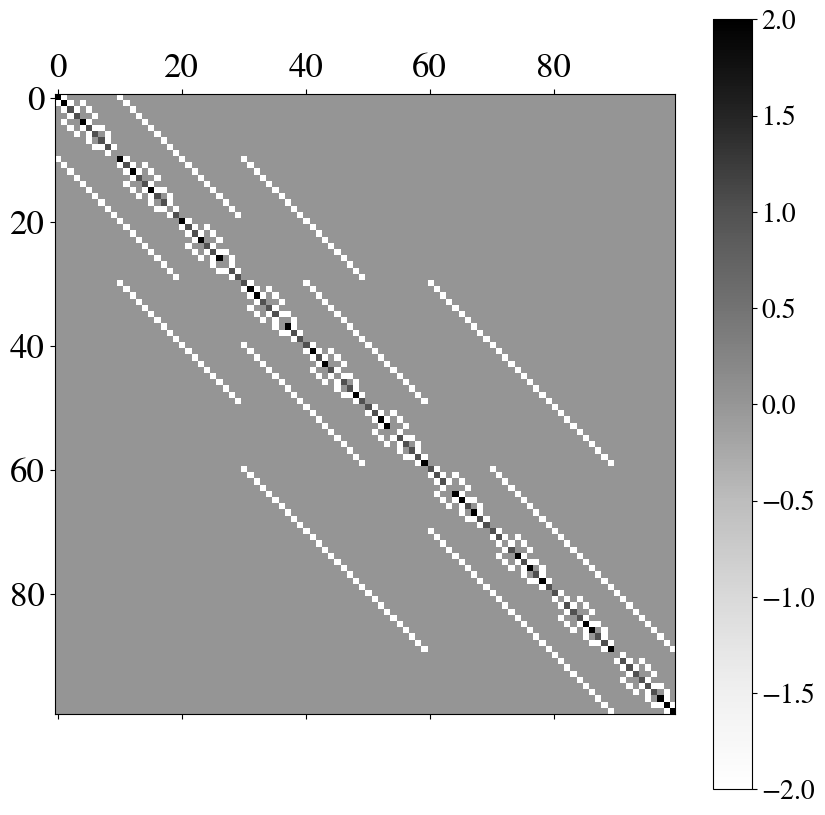

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.matshow(np.real(H), cmap="Greys")
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.tick_params(axis="both", labelsize=25)
plt.show()

In [13]:
t = 2.0
U = 1.0
Nup = 2
Ndown = 1
L = 5

H = hubbard_hamiltonian(t, U, Nup, Ndown, L, boundary_conditions="periodic")
imap = index_map(2, 1, 5)
print(show_states(imap, 5))

{0: ('00011', '00001'), 1: ('00011', '00010'), 2: ('00011', '00100'), 3: ('00011', '01000'), 4: ('00011', '10000'), 5: ('00101', '00001'), 6: ('00101', '00010'), 7: ('00101', '00100'), 8: ('00101', '01000'), 9: ('00101', '10000'), 10: ('00110', '00001'), 11: ('00110', '00010'), 12: ('00110', '00100'), 13: ('00110', '01000'), 14: ('00110', '10000'), 15: ('01001', '00001'), 16: ('01001', '00010'), 17: ('01001', '00100'), 18: ('01001', '01000'), 19: ('01001', '10000'), 20: ('01010', '00001'), 21: ('01010', '00010'), 22: ('01010', '00100'), 23: ('01010', '01000'), 24: ('01010', '10000'), 25: ('01100', '00001'), 26: ('01100', '00010'), 27: ('01100', '00100'), 28: ('01100', '01000'), 29: ('01100', '10000'), 30: ('10001', '00001'), 31: ('10001', '00010'), 32: ('10001', '00100'), 33: ('10001', '01000'), 34: ('10001', '10000'), 35: ('10010', '00001'), 36: ('10010', '00010'), 37: ('10010', '00100'), 38: ('10010', '01000'), 39: ('10010', '10000'), 40: ('10100', '00001'), 41: ('10100', '00010'), 4

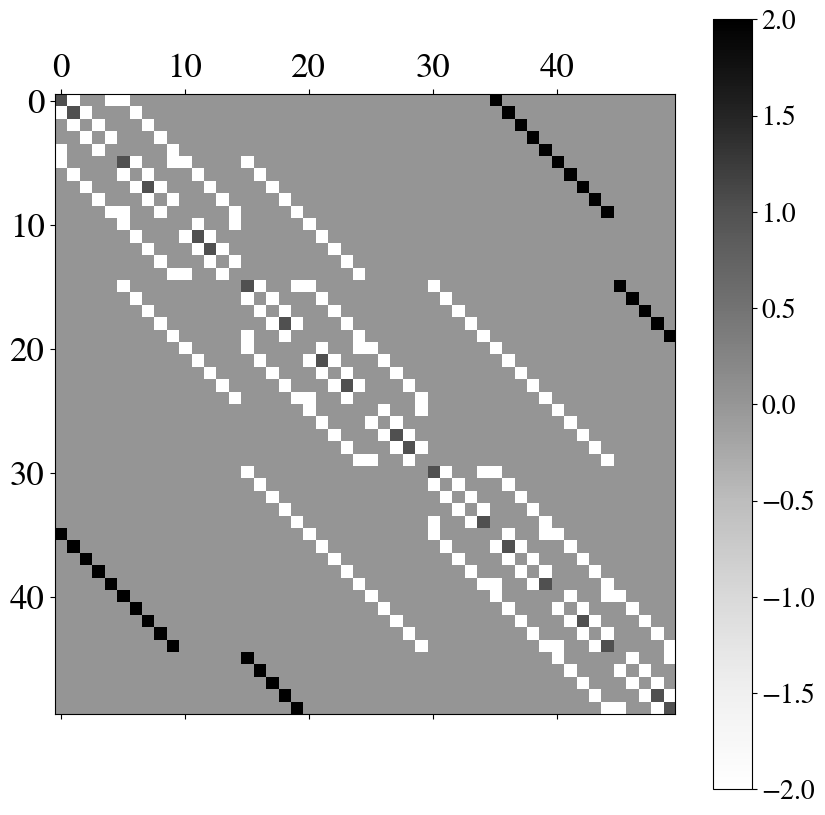

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.matshow(np.real(H), cmap="Greys")
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.tick_params(axis="both", labelsize=25)
plt.show()

In [15]:
# imap = index_map(2, 3, 5)
# show_states(imap, 5)

In [16]:
t = 1.0
Nup = 2
Ndown = 2
L = 6

H = hubbard_hamiltonian(t, 0.0, Nup, Ndown, L)

Us = np.arange(0.0, 10.0, 0.2)
spectrum = np.zeros((len(Us), len(H)))


for idx, U in enumerate(Us):
    H = hubbard_hamiltonian(t, U, Nup, Ndown, L)
    evals, evecs = complete_diagonalization(H)
    spectrum[idx, :] = np.sort(evals)

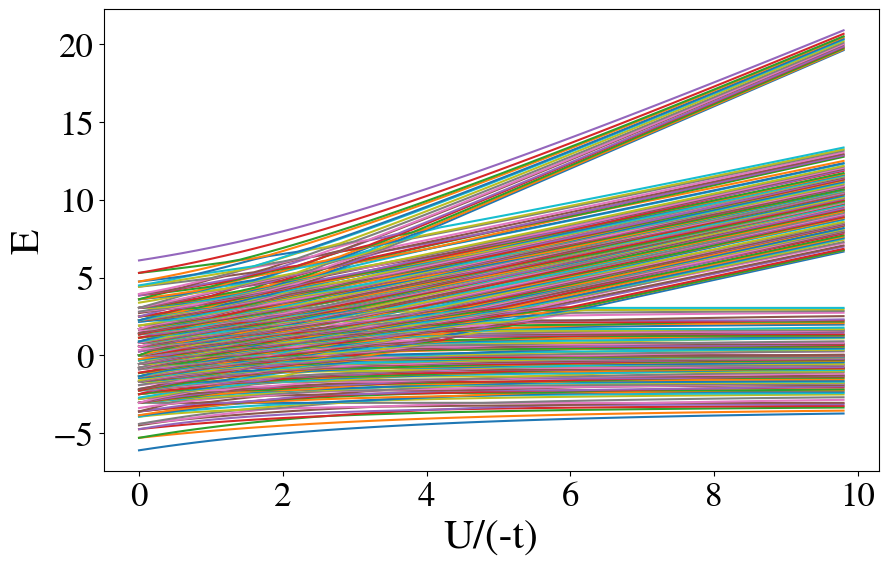

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(H)):
    ax.plot(Us, spectrum[:, i])

ax.tick_params(axis="both", labelsize=25)
ax.set_xlabel("U/(-t)", fontsize=30)
ax.set_ylabel("E", fontsize=30)
plt.show()

In [18]:
t = 1.0
Nup = 3
Ndown = 3
L = 6

H = hubbard_hamiltonian(t, 0.0, Nup, Ndown, L)

Us = np.arange(0.0, 20.2, 
               0.2)
spectrum = np.zeros((len(Us), len(H)))

Es = non_interacting_spectrum(t, Nup, Ndown, L)
Uzeros = np.zeros(len(Es))

for idx, U in enumerate(Us):
    H = hubbard_hamiltonian(t, U, Nup, Ndown, L, boundary_conditions="periodic")
    evals, evecs = complete_diagonalization(H)
    spectrum[idx, :] = np.sort(evals)

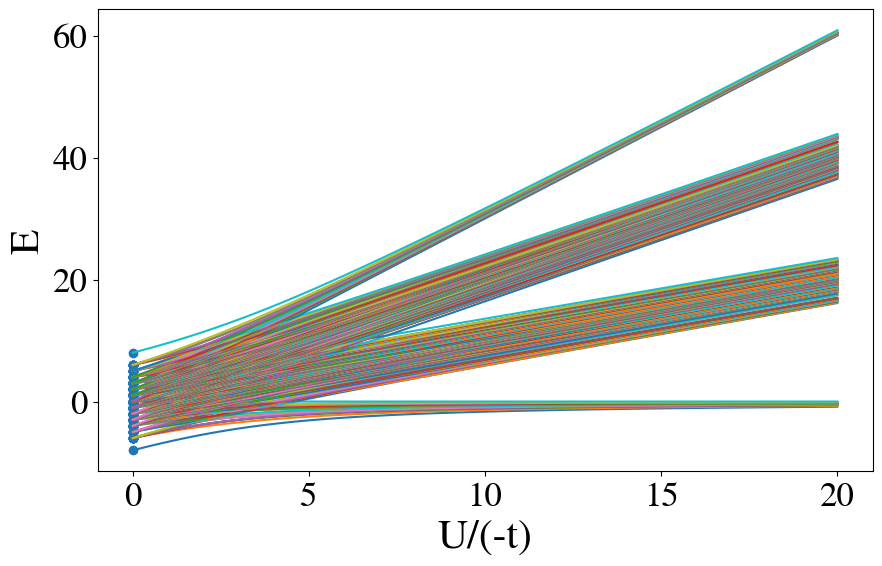

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(H)):
    ax.plot(Us, spectrum[:, i])

ax.scatter(Uzeros, Es)
ax.tick_params(axis="both", labelsize=25)
ax.set_xlabel("U/(-t)", fontsize=30)
ax.set_ylabel("E", fontsize=30)
plt.show()

In [20]:
Es = non_interacting_spectrum(t, Nup, Ndown, L)

In [21]:
t = 1.0
Nup = 2
Ndown = 3
L = 6

H = hubbard_hamiltonian(t, 0.0, Nup, Ndown, L, boundary_conditions="periodic")

In [22]:
print(format((0b1001001^0b1), f"0{10}b"))
print(format((1 << (5 - 2))-1, f"0{10}b"))

0001001000
0000000111


In [23]:
# H = -t*SUM_{j, sigma}[c_{j, sigma}^{dagger}c_{j+1, sigma}+c_{j+1, sigma}^{dagger}c_{j, sigma}]+U*SUM_{j}nj_up*nj_down

L = 6  # system size
N_up = 3
N_down = 3

t = 1.0  # hopping strength
U = 0.0  # onsite interaction strength


basis = qs.basis.spinful_fermion_basis_1d(L=L, Nf=(N_up, N_down))

hop_right = [[t, i, (i+1)%L] for i in range(L)]
hop_left = [[-t, i, (i+1)%L] for i in range(L)]
on_site = [[U, i, i] for i in range(L)]

static_list = [["+-|", hop_left],
              ["-+|", hop_right],
              ["|+-", hop_left],
              ["|-+", hop_right],
              ["n|n", on_site]]

In [24]:
H_hub = qs.operators.hamiltonian(static_list, [], basis=basis)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [25]:
t = 1.0
Nup = 3
Ndown = 3
L = 6

H = hubbard_hamiltonian(t, 0.0, Nup, Ndown, L)

Us = np.arange(0.0, 3.2, 0.1)
spectrum = np.zeros((len(Us), len(H)))

Es = H_hub.eigvalsh()
Uzeros = np.zeros(len(Es))

for idx, U in enumerate(Us):
    H = hubbard_hamiltonian(t, U, Nup, Ndown, L, boundary_conditions="periodic")
    evals, evecs = complete_diagonalization(H)
    spectrum[idx, :] = np.sort(evals)

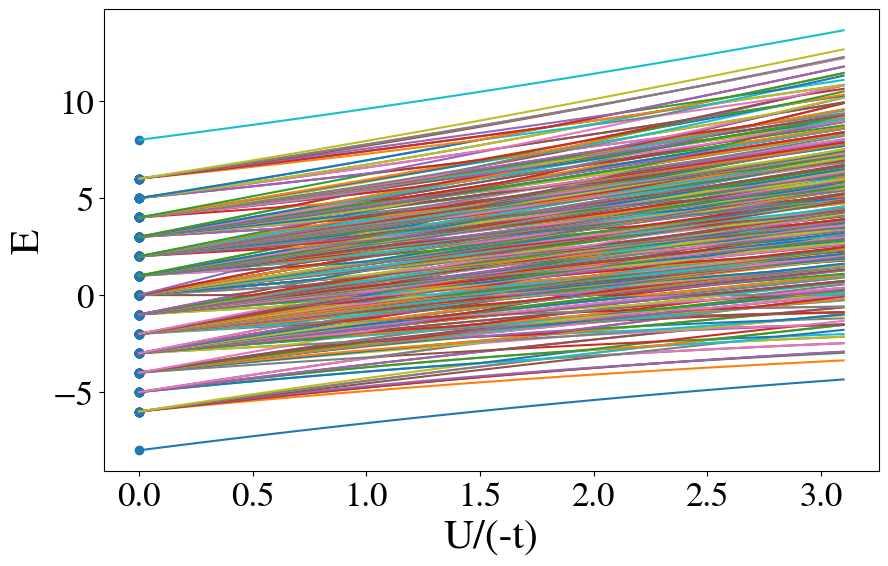

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(H)):
    ax.plot(Us, spectrum[:, i])

ax.scatter(Uzeros, Es)
ax.tick_params(axis="both", labelsize=25)
ax.set_xlabel("U/(-t)", fontsize=30)
ax.set_ylabel("E", fontsize=30)
plt.show()

In [30]:
# H = -t*SUM_{j, sigma}[c_{j, sigma}^{dagger}c_{j+1, sigma}+c_{j+1, sigma}^{dagger}c_{j, sigma}]+U*SUM_{j}nj_up*nj_down

L = 6  # system size
N_up = 3
N_down = 3

t = 1.0  # hopping strength
U = 0.0  # onsite interaction strength


basis = qs.basis.spinful_fermion_basis_1d(L=L, Nf=(N_up, N_down))

hop_right = [[t, i, (i+1)%L] for i in range(L)]
hop_left = [[-t, i, (i+1)%L] for i in range(L)]
on_site = [[1.0, i, i] for i in range(L)]

operator_list0 = [["+-|", hop_left],
                  ["-+|", hop_right],
                  ["|+-", hop_left],
                  ["|-+", hop_right]]

operator_list1 = [["n|n", on_site]]

operator_dict = dict(H0=operator_list0, H1=operator_list1)

In [31]:
H_dict = qs.operators.quantum_operator(operator_dict, basis=basis)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [56]:
from time import time

In [70]:
from scipy.linalg import eigvalsh

In [79]:
Us = np.arange(0.0, 3.2, 0.1)
t = 1.0
Nup = 3
Ndown = 3
L = 6



Us = np.arange(0.0, 10.1, 0.1)

spectrum = np.zeros((len(Us), len(H)))
qspectrum = np.zeros((len(Us), len(H)))

for idx, U in enumerate(Us):

    ti = time()
    params_dict = dict(H0=1.0, H1=U)
    
    #Hqs = H_dict.tohamiltonian(params_dict)
    #qspectrum[idx, : ] = Hqs.eigvalsh()
    
    #H_hub = qs.operators.hamiltonian(static_list, [], basis=basis)
    #qspectrum[idx, :] = H_hub.eigvalsh()
    
    #H = hubbard_hamiltonian(t, U, Nup, Ndown, L, boundary_conditions="periodic")
    #evals, evecs = complete_diagonalization(H)
    #spectrum[idx, :] = eigvalsh(H, overwrite_a=True, driver="evr")

    print("realization {}/{} completed in {:.2f} s".format(idx+1, len(Us), time()-ti))

realization 1/101 completed in 0.10 s
realization 2/101 completed in 0.02 s
realization 3/101 completed in 0.02 s
realization 4/101 completed in 0.02 s
realization 5/101 completed in 0.02 s
realization 6/101 completed in 0.02 s
realization 7/101 completed in 0.02 s
realization 8/101 completed in 0.04 s
realization 9/101 completed in 0.02 s
realization 10/101 completed in 0.02 s
realization 11/101 completed in 0.02 s
realization 12/101 completed in 0.03 s
realization 13/101 completed in 0.02 s
realization 14/101 completed in 0.02 s
realization 15/101 completed in 0.02 s
realization 16/101 completed in 0.02 s
realization 17/101 completed in 0.02 s
realization 18/101 completed in 0.02 s
realization 19/101 completed in 0.02 s
realization 20/101 completed in 0.02 s
realization 21/101 completed in 0.02 s
realization 22/101 completed in 0.03 s
realization 23/101 completed in 0.02 s
realization 24/101 completed in 0.02 s
realization 25/101 completed in 0.02 s
realization 26/101 completed in 0.

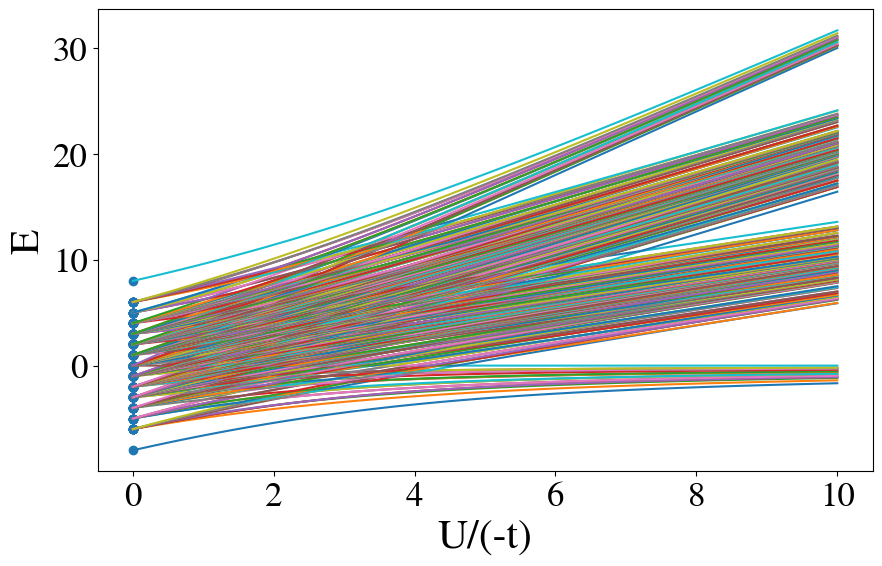

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(H)):
    #ax.plot(Us, qspectrum[:, i])
    ax.plot(Us, spectrum[:, i])

ax.scatter(Uzeros, Es)
ax.tick_params(axis="both", labelsize=25)
ax.set_xlabel("U/(-t)", fontsize=30)
ax.set_ylabel("E", fontsize=30)
plt.show()

In [51]:
print(sum((qspectrum-spectrum)[0]))

-4.990610479878642e-14


In [75]:
np.__config__.show()

Build Dependencies:
  blas:
    detection method: pkgconfig
    found: true
    include directory: /opt/_internal/cpython-3.12.7/lib/python3.12/site-packages/scipy_openblas64/include
    lib directory: /opt/_internal/cpython-3.12.7/lib/python3.12/site-packages/scipy_openblas64/lib
    name: scipy-openblas
    openblas configuration: OpenBLAS 0.3.29  USE64BITINT DYNAMIC_ARCH NO_AFFINITY
      Haswell MAX_THREADS=64
    pc file directory: /project/.openblas
    version: 0.3.29
  lapack:
    detection method: pkgconfig
    found: true
    include directory: /opt/_internal/cpython-3.12.7/lib/python3.12/site-packages/scipy_openblas64/include
    lib directory: /opt/_internal/cpython-3.12.7/lib/python3.12/site-packages/scipy_openblas64/lib
    name: scipy-openblas
    openblas configuration: OpenBLAS 0.3.29  USE64BITINT DYNAMIC_ARCH NO_AFFINITY
      Haswell MAX_THREADS=64
    pc file directory: /project/.openblas
    version: 0.3.29
Compilers:
  c:
    commands: cc
    linker: ld.bfd
    na